# Analyis
## New Functionality

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, measure
)
import math
from scipy import signal
from skimage.filters import threshold_multiotsu, threshold_otsu
from glob import glob
import shutil
import os
import re
import warnings
import pandas as pd
from matplotlib.ticker import StrMethodFormatter
from scipy.stats import gaussian_kde
from scipy.stats.stats import spearmanr
from skimage.filters import threshold_multiotsu, threshold_li
from skimage import morphology
from skimage.morphology import disk
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from pathlib import Path
from skimage.segmentation import watershed, clear_border
warnings.filterwarnings('ignore')
import itertools
import seaborn as sns
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap

In [70]:
def slice(im3d, savefig = False):
    #TODO rename to slicer
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    if savefig is True:
        plt.savefig('slice_overview.png')
    return chosen

In [71]:
def slice_center_mass(im3d, savefig = False):
    #TODO rename to slicer
    chosen = []
    centre_of_mass = ndimage.center_of_mass(im3d)
    com = centre_of_mass[0]
    if com % 1 <= 0.5:
        centre = math.floor(com)
        start = centre - 5
        stop = centre + 5
        for i in range(start, stop+1):
            chosen.append(i)
    else:
        centre = math.ceil(com)
        start = centre - 5
        stop = centre + 5
        for i in range(start, stop+1):
            chosen.append(i)
    #if savefig is True:
        #plt.savefig('slice_overview.png')
    return chosen

In [72]:
#TODO different slicing strategies

In [73]:
def display(im3d, cmap="gray", step=1, chosen = None, savefig = False):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    if savefig is True:
        plt.savefig('slice_gallery.png')

In [74]:
#TODO make saving conditional

In [75]:
def slice_manual(im3d,start,stop, savefig = False):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop+1)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    if savefig is True:
        plt.savefig('slice_overview.png')
    return chosen
    

In [76]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [77]:
#TODO channel chooser

In [78]:
#slice input cell, output csv of hoechst and edu pixel values for each slice within the segmented chromatin

F-ara-EdU = channel 3, Hoechst = channel 4

In [79]:

def slice_folder(inpath,channel,save_path,save_slice=True):
    path = os.walk(inpath)
    all_dataframes = []
    #print(f"rep:{Path(inpath).stem}")
    #print(f"cond: {Path(inpath).parent.stem}")
    for root, directories, files in path:
        for directory in directories:
            #print(directory)
            #print(os.path.join(root,directory))
            os.chdir(os.path.join(root,directory))
            subfiles = glob('*registered.tif', recursive=True)
            #print(subfiles)
            # cycles through default colors
            #plot0 = plt.plot(0,0)
            #cond0_color = plot0[0].get_color()   
            for file in subfiles:
                data = io.imread(os.path.join(root,directory,file))
                channel_data = data[:,:,:,channel-1]
                os.chdir(os.path.join(root,directory))
                chosen = slice_center_mass(channel_data, savefig = True)
                if (save_slice is True):
                    display(channel_data, chosen=chosen, savefig = True)
                #print(os.path.join(root,directory,file))
                print(file)
                print(chosen)
                all_coeff = []
                all_pvalue = []
                all_slice = []
                all_area = []
                all_pixel_values_edu = []
                all_pixel_values_hoechst = []
                if not os.path.exists(os.path.join(root,directory,"slices")):
                    os.mkdir(os.path.join(root,directory,"slices"))
                for slicing in chosen:
                    if not os.path.exists(os.path.join(root,directory,"slices", str(slicing))):
                        os.mkdir(os.path.join(root,directory,"slices", str(slicing)))
                    os.chdir(os.path.join(root,directory,"slices", str(slicing)))
                    filestring = file[:-4] + "_slice_" + str(slicing) + ".tif"
                    filestring_mask = file[:-4] + "_maskotsu_" + str(slicing) + ".tif"
                    #print(filestring)
                    #TODO: Make the channels choosable
                    data_edu = data[slicing,:,:,2]
                    data_hoechst = data[slicing,:,:,3]
                    # The input image.
                    image = data_hoechst

                    #otsu thresholding to generate binary mask
                    thresh = threshold_otsu(image)
                    #generate mask
                    mask = image > thresh

                    #Clear borders, get rid of cells which touch the edge of the image
                    cleared = clear_border(mask)

                    #get rid of the edge cases in the regions of interest, exclude things which are in regions but not in the cleared mask
                    #cleared_regions = np.logical_and(regions, cleared)
                    
                    #remove debris and other small objects below a certain size e.g. micronuclei
                    remove_debris = morphology.remove_small_objects(cleared, 3200)
                    
                    #set labels 
                    labels = measure.label(remove_debris)
                    #Measure properties
                    #set properties
                    props = measure.regionprops(labels)
                                                          
                    #create the csv data:
                    flat_edu = data_edu.flatten()
                    flat_hoechst = data_hoechst.flatten()
                    flat_cleared_remove_debris = remove_debris.flatten()
                    all_data = pd.DataFrame(zip(flat_edu,flat_hoechst, flat_cleared_remove_debris),columns=["edu","hoechst", "cleared"])

                    #filter relevant data into new dataframe. Only values which are in cleared and also in regions chosen.

                    regions_filtered_data = all_data[all_data["cleared"] == True]
                    
                    
                    regions_filtered_data = regions_filtered_data[['edu','hoechst']]
                
  
                    if save_path is not None:
                        print("SAVED")
                        replicate = Path(inpath).stem
                        cond = Path(inpath).parent.stem
                        regions_filtered_data.to_csv(f'{save_path}/{cond}_{replicate}_{slicing}.csv', index = False)
                

# Apply to input images

In [19]:
base_path = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/facs_like_plots/images/"
conditions = next(os.walk(base_path))[1]
#remove hidden folder created by jupyter:
clean_conditions = [c for c in conditions if not re.match(r'^\.', c)]
conditions = sorted(clean_conditions)
conditions

['fully_g2', 'fully_prometa', 'hemi_g2', 'hemi_prometa']

In [20]:
hemi_prometa = [c for c in conditions if re.match(r'hemi_prometa', c)]

In [25]:
for condition in hemi_prometa:
    replicates = next(os.walk(os.path.join(base_path,condition)))[1]
    clean_replicates = [c for c in replicates if not re.match(r'^\.', c)]
    replicates = sorted(clean_replicates)
    print(f'CONDITION: {condition}')
    print(f'REPLICATES: {replicates}')
    for replicate in replicates:
        folder_to_slice = os.path.join(base_path,condition,replicate)
        print(folder_to_slice)
        slice_folder(folder_to_slice, 3, "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig_by_fig/ext_data_fig1/panel_e/csv_files_output/")      
        #pass
plt.close("all")

CONDITION: hemi_prometa
REPLICATES: ['rep1']
/groups/gerlich/members/PaulBatty/Paper_preparation/figures/facs_like_plots/images/hemi_prometa/rep1
220207_5389_WT_c2_rep2_prometa_60min_stlc_hemi_zoom5-03-77.czi #2.tif_registered.tif
[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED


In [24]:
fully_prometa = [c for c in conditions if re.match(r'fully_prometa', c)]

In [26]:
for condition in fully_prometa:
    replicates = next(os.walk(os.path.join(base_path,condition)))[1]
    clean_replicates = [c for c in replicates if not re.match(r'^\.', c)]
    replicates = sorted(clean_replicates)
    print(f'CONDITION: {condition}')
    print(f'REPLICATES: {replicates}')
    for replicate in replicates:
        folder_to_slice = os.path.join(base_path,condition,replicate)
        print(folder_to_slice)
        slice_folder(folder_to_slice, 3, "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig_by_fig/ext_data_fig1/panel_d/csv_files_output/")      
        #pass
plt.close("all")

CONDITION: fully_prometa
REPLICATES: ['rep1']
/groups/gerlich/members/PaulBatty/Paper_preparation/figures/facs_like_plots/images/fully_prometa/rep1
220207_5389_WT_c2_rep2_prometa_60min_stlc_fully_zoom5-03-25.czi #8.tif_registered.tif
[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED
SAVED


In [31]:
#read in csv files with the pixel values for single slice from the z-stack

In [57]:
#one sister labelled
df = pd.read_csv("/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig_by_fig/ext_data_fig1/panel_e/csv_files_output/hemi_prometa_rep1_49.csv")
df = df.dropna()
#two sister labelled
df2 = pd.read_csv("/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig_by_fig/ext_data_fig1/panel_d/csv_files_output/fully_prometa_rep1_49.csv")
df2 = df2.dropna()



In [58]:
#calculate correlation coefficient - one sister labelled, for the chosen slice

In [59]:
#correlation_coeff, pvalue = spearmanr(dataframe.loc[:, "hoechst"], dataframe.loc[:, "edu"])
#correlation_coeff


#hemi prometa = df3
rows = df.iloc[0]
for row in df:
    correlation_coeff = spearmanr(df["hoechst"], df.loc[0:, "edu"])
    print(correlation_coeff)


SpearmanrResult(correlation=0.4958129860389304, pvalue=0.0)
SpearmanrResult(correlation=0.4958129860389304, pvalue=0.0)


In [60]:
#calculate correlation coefficient - two sister labelled, for the chosen slice

In [61]:
#correlation_coeff, pvalue = spearmanr(dataframe.loc[:, "hoechst"], dataframe.loc[:, "edu"])
#correlation_coeff


#fully prometa = df4
rows = df2.iloc[0]
for row in df2:
    correlation_coeff = spearmanr(df2["hoechst"], df2.loc[0:, "edu"])
    print(correlation_coeff)

SpearmanrResult(correlation=0.8715640224568967, pvalue=0.0)
SpearmanrResult(correlation=0.8715640224568967, pvalue=0.0)


In [62]:
#plot pixel values, normalise them onto the same scale

In [63]:
df_norm = df.copy()
for column in df_norm.columns:
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min()) 
    
    
df2_norm = df2.copy()
for column in df2_norm.columns:
    df2_norm[column] = (df2_norm[column] - df2_norm[column].min()) / (df2_norm[column].max() - df2_norm[column].min()) 
    

In [88]:
#one sister labelled prometa
x = df_norm["edu"]
y = df_norm["hoechst"]

#two sister labelled prometa
x2 = df2_norm["edu"]
y2 = df2_norm["hoechst"]


In [85]:
#density scatter plot function using mpl_scatter_density

In [84]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='turbo')
    fig.colorbar(density, label='Number of points per pixel')

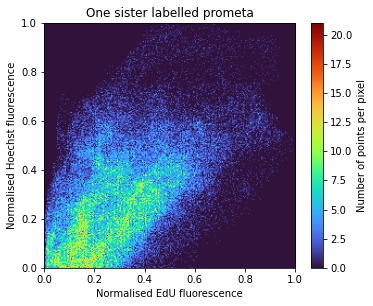

<Figure size 432x288 with 0 Axes>

In [86]:
fig = plt.figure()
fig.set_size_inches(5.625, 4.5)
using_mpl_scatter_density(fig, x, y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Normalised EdU fluorescence")
plt.ylabel("Normalised Hoechst fluorescence")
plt.title("One sister labelled prometa")
plt.show()
resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig_by_fig/ext_data_fig1/panel_e/plots/"
sns.despine()
fig.savefig(os.path.join(resultsdir, "wt_prometa_one_sister_labelled_pixel_scatter_example1.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(resultsdir, "wt_prometa_one_sister_labelled_pixel_scatter_example1.png"), bbox_inches="tight")

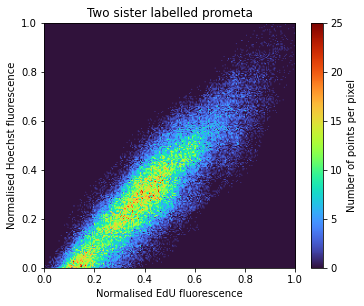

<Figure size 432x288 with 0 Axes>

In [89]:
fig = plt.figure()
fig.set_size_inches(5.625, 4.5)
using_mpl_scatter_density(fig, x2, y2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Normalised EdU fluorescence")
plt.ylabel("Normalised Hoechst fluorescence")
plt.title("Two sister labelled prometa")
plt.show()
resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig_by_fig/ext_data_fig1/panel_d/plots/"
sns.despine()
fig.savefig(os.path.join(resultsdir, "wt_prometa_two_sister_labelled_pixel_scatter_example1.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(resultsdir, "wt_prometa_two_sister_labelled_pixel_scatter_example1.png"), bbox_inches="tight")